In [ ]:
%%writefile Primos_Gemelos.c
#include <stdio.h> 
#include <stdlib.h>
#include <time.h>
#include <sys/time.h>

float time_diff(struct timeval *start, struct timeval *end){
    return (end->tv_sec - start->tv_sec) + 1e-6*(end->tv_usec - start->tv_usec);
}

int main(int argc, char **argv ){ 

  int n = atoi(argv[1]);
  //time_t Inicio = time(NULL);

  struct timeval start;
  struct timeval end;

  gettimeofday(&start, NULL);// <----- tiempo1

  int Primo_Precedente = 0, valoracion = 0, Primer_Primo = 0, Primo_Terminante = 0;
  
  for(int i = 2; i <=n; i++){
    int flag = 0;
    for (int j = 2; j <= i/2; j++){
      if(i % j == 0){
        flag = 1;
        break;
      }
    }
    if(flag == 0 && i != 1){
      if(Primo_Terminante == 0){
        Primer_Primo = i;
        Primo_Terminante = i;
      }else{
        Primo_Precedente = Primo_Terminante;
        Primo_Terminante = i; 
      }
       //comparar ultimo primo con primer primo
      int Diferencia = Primo_Terminante - Primo_Precedente;
      if(Diferencia == 2 && i != 2){
        printf("Son Primos Primos Gemelos = [%d, %d]\n",Primo_Precedente,Primo_Terminante);
        valoracion++;
      }
    }  
  }
  int total = 0;
  if(total == 0){
    for(int i = 0; i < n; i++){
      total = valoracion;
    }
    printf("Total de Números Primos Gemelos: %d\n", total);
  }
  gettimeofday(&end, NULL); // <----- tiempo2

  printf("Tiempo ejecutado en: %f segundos",time_diff(&start, &end) );

  //time_t Final = time(NULL);
  //printf("Tiempo ejecutado en %d segundos", int(Final - Inicio));
  return 0;
}                

Writing Primos_Gemelos.c


In [ ]:
%%script bash
echo "Contando primos gemelos en secuencial"
gcc Primos_Gemelos.c -o PrimosGemelos -lm
./PrimosGemelos 2000000 >> tiempo_sec.dat

Contando primos gemelos en secuencial


In [ ]:
%%writefile Primos_Gemelos_Version1.c
#include "mpi.h"
#include <stdio.h> 
#include <stdlib.h>

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main(int argc, char **argv ){
  MPI_Init( &argc , &argv);
  int id, i, np, n, inicio, fin, num_elems_rango, root = 0;

  // Para calcular los tiempos
  double t1,t2;

  MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
  MPI_Comm_rank(MPI_COMM_WORLD, &id); // Valor de nuestro identificador
  
  n = atoi(argv[1]);
  inicio = BLOCK_LOW(id,np,n)+1; // para que empiece en 1
  fin = BLOCK_HIGH(id,np,n)+1;
  num_elems_rango = BLOCK_SIZE(id,np,n);

  //time_t Inicio = time(NULL);

  MPI_Barrier(MPI_COMM_WORLD);
  t1 = MPI_Wtime();

  if(id == 0){
        printf("\nPrograma que encuentra el numero de primos gemelos en el rango de %d",n);
    }

  int Primo_Precedente = 0, valoracion = 0, Primer_Primo = 0, Primo_Terminante = 0;
  
  for(int i = inicio; i <= fin; i++){
    int flag = 0;
    for (int j = 2; j <= i/2; j++){
      if(i % j == 0){
        flag = 1;
        break;
      }
    }
    if(flag == 0 && i != 1){
      if(Primo_Terminante == 0){
        Primer_Primo = i;
        Primo_Terminante = i;
      }else{
        Primo_Precedente = Primo_Terminante;
        Primo_Terminante = i; 
      }
      int Diferencia = Primo_Terminante - Primo_Precedente;
      if(Diferencia == 2 && i != 2){
        //printf("\nSon Primos Primos Gemelos = [%d, %d]\n",Primo_Precedente,Primo_Terminante);
        valoracion++;
      }
    }
  }
  if(id != np-1 && Primo_Terminante !=0){ // Si no es el ultimo, busca al menos un primo
    MPI_Send(&Primo_Terminante, 1, MPI_INT, id+1, 32, MPI_COMM_WORLD);
  }
  if(id != root){
    MPI_Recv(&Primo_Terminante, 1 , MPI_INT, id-1, 32, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    if(Primer_Primo == 0 && id != np-1){  // Si no encuentra ningun primo, se envia el primo que recibio
      MPI_Send(&Primo_Terminante, 1, MPI_INT, id+1, 32, MPI_COMM_WORLD);
    }
    // Compara el primo terminante con el primer primo
    int Diferencia = Primer_Primo - Primo_Terminante;
    if(Diferencia == 2) valoracion++;
  }
  MPI_Send(&valoracion, 1, MPI_INT, root, 9, MPI_COMM_WORLD);
  
  if(id == root){
    int total = 0;
    for(i = 0; i < np; i++){
      MPI_Recv(&valoracion, 1, MPI_INT, i, 9, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
      total += valoracion;
    }
    printf("\nTotal de Números Primos Gemelos: %d\n", total);
    t2 = MPI_Wtime(); // <----- tiempo2
    float tiempo = t2-t1;
    printf("Tiempo ejecutado en: %d procesos y %f segundos \n", np, tiempo); 
  }

  //printf("\nTiempo total al calcular la cantidad de numeros primos gemelos fue: %.10f segundos \n", t2-t1);

  MPI_Finalize();

  //time_t Final = time(NULL);
  //printf("Tiempo ejecutado en %d segundos", int(Final - Inicio));
  //return 0;
}       

Writing Primos_Gemelos_Version1.c


In [ ]:
%%script bash
mpicc Primos_Gemelos_Version1.c -o PrimosGemelos_V1 -lm
rm tiempos_v1.dat
echo "Primos Gemelos en paralelo 1"
for i in $(seq 1 16)
do
    echo " ----- Usando $i procesos"
    mpirun --allow-run-as-root -np $i PrimosGemelos_V1 2000000 >> tiempos_v1.dat    
done

Primos Gemelos en paralelo 1
 ----- Usando 1 procesos
 ----- Usando 2 procesos
 ----- Usando 3 procesos
 ----- Usando 4 procesos
 ----- Usando 5 procesos
 ----- Usando 6 procesos
 ----- Usando 7 procesos
 ----- Usando 8 procesos
 ----- Usando 9 procesos
 ----- Usando 10 procesos
 ----- Usando 11 procesos
 ----- Usando 12 procesos
 ----- Usando 13 procesos
 ----- Usando 14 procesos
 ----- Usando 15 procesos
 ----- Usando 16 procesos


rm: cannot remove 'tiempos_v1.dat': No such file or directory


In [ ]:
%%writefile Primos_Gemelos_Version2.c
#include "mpi.h"
#include <stdio.h> 
#include <stdlib.h>

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

int main(int argc, char **argv ){
  MPI_Init(&argc , &argv);
  int id, i, np, n, inicio, fin, num_elems_rango, root = 0, sendbuf, recvbuf;

  // Para calcular los tiempos
  double t1,t2;

  MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
  MPI_Comm_rank(MPI_COMM_WORLD, &id); // Valor de nuestro identificador
  
  n = atoi(argv[1]);
  inicio = BLOCK_LOW(id,np,n)+1; // para que empiece en 1
  fin = BLOCK_HIGH(id,np,n)+1;
  num_elems_rango = BLOCK_SIZE(id,np,n);

  //time_t Inicio = time(NULL);

  MPI_Barrier(MPI_COMM_WORLD);  // Sincronización
  t1 = MPI_Wtime();

  if(id == 0){
        printf("\nPrograma que encuentra el numero de primos gemelos en el rango de %d\n",n);
    }

  if (np > n/2 && id == root){
    printf("Los Procesos son desmesuradamente... Procure con un número menor\n");
    MPI_Abort(MPI_COMM_WORLD,99);
  }

  //if(id == 0){
        //printf("Programa que encuentra el numero de primos gemelos en el rango de %d\n",n);
    //}

  int Primo_Precedente = 0, valoracion = 0, Primer_Primo = 0, Primo_Terminante = 0;
  
  for(int i = inicio; i <= fin; i++){
    int flag = 0;
    for (int j = 2; j <= i/2; j++){
      if(i % j == 0){
        flag = 1;
        break;
      }
    }
    if(flag == 0 && i != 1){
      if(Primo_Terminante == 0){
        Primer_Primo = i;
        Primo_Terminante = i;
      }else{
        Primo_Precedente = Primo_Terminante;
        Primo_Terminante = i; 
      }
      int Diferencia = Primo_Terminante - Primo_Precedente;
      if(Diferencia == 2 && i != 2){
       //printf("Son Primos Primos Gemelos = [%d, %d]\n",Primo_Precedente,Primo_Terminante);
        valoracion++;
      }
    }
  }
  if(id != np-1 && Primo_Terminante != 0){ // Si no es el ultimo, busca al menos un primo
    MPI_Send(&Primo_Terminante, 1, MPI_INT, id+1, 32, MPI_COMM_WORLD);
  }
  if(id != root){
    MPI_Recv(&Primo_Terminante, 1 , MPI_INT, id-1, 32, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    if(Primer_Primo == 0 && id != np-1){  // Si no encuentra ningun primo, se envia el primo que recibio
      MPI_Send(&Primo_Terminante, 1, MPI_INT, id+1, 32, MPI_COMM_WORLD);
    }
    // Compara el primo terminante con el primer primo
    int Diferencia = Primer_Primo - Primo_Terminante;
    if(Diferencia == 2) valoracion++;
  }

  //MPI_Send(&valoracion, 1, MPI_INT, root, 9, MPI_COMM_WORLD);

  sendbuf = valoracion;
  MPI_Reduce(&sendbuf, &recvbuf, 1, MPI_INT, MPI_SUM, root, MPI_COMM_WORLD);
  
  //int total = 0;
  if(id == root){
    /*for(i = 0; i < np; i++){
      MPI_Recv(&valoracion, 1, MPI_INT, i, 9, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
      total += valoracion;*/
      printf("Total de Números Primos Gemelos: %d\n", recvbuf);
    //}
  }

  MPI_Barrier(MPI_COMM_WORLD);  // sincronización
  t2 = MPI_Wtime();
  float tiempo = t2-t1;

  if(id == root){
    //printf("\nTiempo total al calcular la cantidad de numeros primos gemelos fue: %.10f segundos \n", t2-t1);
    printf("Tiempo ejecutado en: %d procesos y %f segundos \n", np, tiempo);
    }
  
  MPI_Finalize();

  //time_t Final = time(NULL);
  //printf("Tiempo ejecutado en %d segundos", int(Final - Inicio));
  //return 0;
}


Overwriting Primos_Gemelos_Version2.c


In [ ]:
%%script bash
mpicc Primos_Gemelos_Version2.c -o PrimosGemelos_V2 -lm
rm tiempos_v2.dat
echo "Primos Gemelos en paralelo 2"
for i in $(seq 1 16)
do
    echo " ----- Usando $i procesos"
    mpirun --allow-run-as-root -np $i PrimosGemelos_V2 2000000 >> tiempos_v2.dat    
done

Primos Gemelos en paralelo 2
 ----- Usando 1 procesos
 ----- Usando 2 procesos
 ----- Usando 3 procesos
 ----- Usando 4 procesos
 ----- Usando 5 procesos
 ----- Usando 6 procesos
 ----- Usando 7 procesos
 ----- Usando 8 procesos
 ----- Usando 9 procesos
 ----- Usando 10 procesos
 ----- Usando 11 procesos
 ----- Usando 12 procesos
 ----- Usando 13 procesos
 ----- Usando 14 procesos
 ----- Usando 15 procesos
 ----- Usando 16 procesos


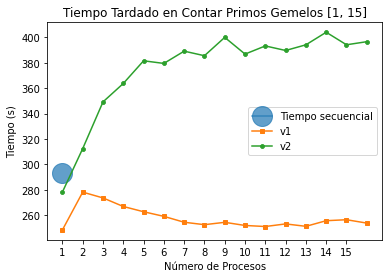

In [2]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 293.345886

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

tiempos_ms_v1 = np.array([248.381134,278.151794,273.582916,266.844208,262.700989,
                          259.062225,254.423782,252.506180,254.360626,251.886932,
                          251.056458,253.115509,251.208420,255.641342,256.413208,253.756653])

tiempos_ms_v2 = np.array([278.238373,312.427826,349.234528,363.735474,381.611298,
                          379.548798,389.204681,385.612579,400.065308,386.900299,
                          393.317413,389.739136,394.206360,404.106781,394.233551,396.66299])

fig, ax = plt.subplots()

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.plot(procesos,tiempos_ms_v1,marker = 's',markersize = 4,label="v1")
ax.plot(procesos,tiempos_ms_v2,marker = '8',markersize = 4,label="v2")

plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo Tardado en Contar Primos Gemelos [1, 15]')
plt.legend()
plt.show()

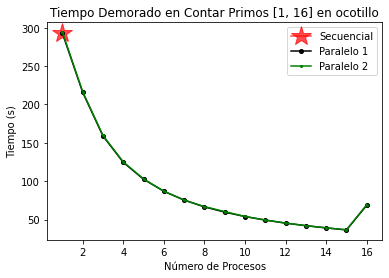

In [6]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 292.787048

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

tiempos_ms_v1 = np.array([292.797028,215.687759,158.786606,124.459496,102.476219,
                          86.834114,75.337914,66.449844,59.597786,53.881958,
                          49.268665,45.260036,41.977051,39.039631,36.451069,68.593887])

tiempos_ms_v2 = np.array([294.121307,216.590134,159.526123,125.103981,102.881119,
                          86.877831,75.318192,66.828568,60.352173,53.941174,
                          49.323467,45.436085,41.977783,39.183849,36.614189,69.410164])

fig, ax = plt.subplots()
ax.plot([1],[tiempo_secuencial],marker='*',markersize=20,alpha=0.7,color='r', label='Secuencial')
ax.plot(procesos,tiempos_ms_v1,marker = 'o',markersize = 4,color='k',label="Paralelo 1")
ax.plot(procesos,tiempos_ms_v2,marker = '.',markersize = 4,color='g',label="Paralelo 2")

plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo Demorado en Contar Primos [1, 16] en ocotillo')
plt.legend()
plt.show()